In [ ]:
# Import relevant libraries

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from mug_training_utils import *
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# Load images
mug_images, mug_labels = load_images_and_labels('mug_train', 1)
non_mug_images, non_mug_labels = load_images_and_labels('non_mug_train', 0)

# Concatenate images into X and labels into y
train_set_X_orig = np.concatenate((mug_images, non_mug_images[:len(mug_images)]))
train_set_y_orig = np.concatenate((mug_labels, non_mug_labels[:len(mug_images)])).reshape(-1, 1)

# Set up a random seed and create a randomly shuffled list of indices
seed = 42
np.random.seed(seed)
indices = np.arange(len(train_set_X_orig))
np.random.shuffle(indices)

# Shuffle X and y using the shuffled indices
train_set_X = train_set_X_orig[indices]
train_set_y = train_set_y_orig[indices].T

# Normalise values for each pixel
train_set_x = train_set_X / 255.
print(train_set_x.shape)

                                

(1504, 224, 224, 3)


Load images to create test set

In [4]:
# Load images
mug_test, mug_test_labels = load_images_and_labels('mug_test', 1)

# Concatanate test set with the latter half of the non-mug images from the training set that we haven't used
test_set_X_orig = np.concatenate((mug_test, non_mug_images[len(mug_images)+1:len(mug_images)+1+len(mug_test)]))
test_set_y_orig = np.concatenate((mug_test_labels, non_mug_labels[len(mug_images)+1:len(mug_images)+1+len(mug_test)])).reshape(-1, 1)

# Similarly set up a random seed and create a randomly shuffled list of indices
seed = 42
np.random.seed(seed)
indices = np.arange(len(test_set_X_orig))
np.random.shuffle(indices)

# Shuffle X and y using the shuffled indices
test_set_X = test_set_X_orig[indices]
test_set_y = test_set_y_orig[indices].T

# Normalise values for each pixel
test_set_x = test_set_X /255

In [5]:
# Define the classes for later use
classes = [b'not a mug', b'a mug']

We plot a random image of the train set to see what we're working with

y = [0], it's not a mug


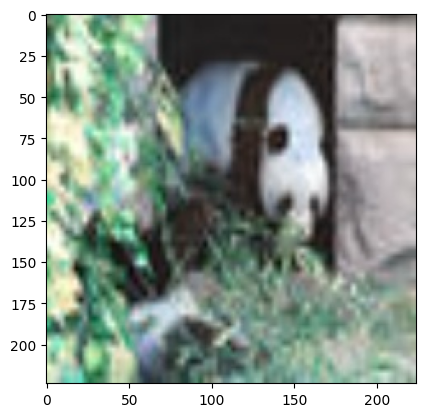

In [7]:
index = 190
plt.imshow(train_set_X[index])
print ("y = " + str(train_set_y[:,index]) + ", it's " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8"))

In [6]:
# Define the number of traiing examples and the image dimensions
m_train = train_set_X.shape[0]
num_px = train_set_X[0].shape[0]

print ("Number of training examples: m_train = " + str(m_train))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_X.shape))
print ("train_set_y shape: " + str(train_set_y.shape))

Number of training examples: m_train = 1504
Height/Width of each image: num_px = 224
Each image is of size: (224, 224, 3)
train_set_x shape: (1504, 224, 224, 3)
train_set_y shape: (1, 1504)


Here we choose to start with a simple model with  a few stacked dense layers and a sigmoid output layer.

In [7]:
# Building a simple sigmoid model
sigmoid_model = Sequential()
sigmoid_model.add(Flatten(input_shape=(224, 224, 3)))
sigmoid_model.add(Dense(128, activation='relu'))
sigmoid_model.add(Dense(64, activation='relu'))
sigmoid_model.add(Dense(1, activation='sigmoid'))

sigmoid_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

sigmoid_model.fit(train_set_x, train_set_y.T, batch_size=10,
          epochs=20, validation_split=0.1)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - accuracy: 0.5747 - loss: 9.8292 - val_accuracy: 0.6623 - val_loss: 1.1991
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.6047 - loss: 2.6599 - val_accuracy: 0.5364 - val_loss: 3.4755
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.6606 - loss: 1.2756 - val_accuracy: 0.5563 - val_loss: 1.0357
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.6790 - loss: 0.7270 - val_accuracy: 0.5828 - val_loss: 1.1530
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.6899 - loss: 0.6827 - val_accuracy: 0.7219 - val_loss: 0.5430
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.7510 - loss: 0.5141 - val_accuracy: 0.6424 - val_loss: 0.8777
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.6815 - loss: 0.7363 - val_accuracy: 0.7285 - val_loss: 0.5724
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.7803 - loss: 0

Let's look at the accuracy of the model.

In [19]:
test_set_x_resize = np.array([cv2.resize(img, (224, 224)) for img in test_set_x])

# Normalize the images to the range [0, 1]
test_set_x_normalized = test_set_x_resize.astype(np.float32)

# Make predictions on the entire batch at once
predictions = sigmoid_model.predict(test_set_x_normalized)

# Convert predictions to binary classes based on threshold
predicted_classes = (predictions > 0.5).astype(int)

test_set_y_flat = test_set_y.flatten()
predicted_classes_flat = predicted_classes.flatten() 

# Calculate accuracy
accuracy = np.mean(test_set_y_flat == predicted_classes_flat)

# Print the accuracy
print('The accuracy of the model is: {:.2f}%'.format(accuracy * 100))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
The accuracy of the model is: 71.14%


This is about the same as we expected, considering the model performed similarly as it did on the train set. Let's try to build a convolutional model to see how it does. 

In [20]:
# Building a convolutional model
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(128, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(1, activation='sigmoid'))  # For binary classification

conv_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

conv_model.fit(train_set_x, train_set_y.T, batch_size=20,
          epochs=20, validation_split=0.1)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 534ms/step - accuracy: 0.6038 - loss: 1.8627 - val_accuracy: 0.6689 - val_loss: 0.5909
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.7678 - loss: 0.5266 - val_accuracy: 0.7616 - val_loss: 0.4847
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 485ms/step - accuracy: 0.8573 - loss: 0.3680 - val_accuracy: 0.7285 - val_loss: 0.6216
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 478ms/step - accuracy: 0.8757 - loss: 0.3353 - val_accuracy: 0.7682 - val_loss: 0.4813
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 484ms/step - accuracy: 0.9320 - loss: 0.2137 - val_accuracy: 0.8013 - val_loss: 0.5304
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 476ms/step - accuracy: 0.9464 - loss: 0.1505 - val_accuracy: 0.7881 - val_loss: 0.5337
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 477ms/step - accuracy: 0.9490 - loss: 0.1159 - val_accuracy: 0.7815 - val_loss: 0.5534
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 468ms/step - accuracy: 0.9683 - loss: 0.0949 - val_accu

We can handpick some images to get predictions from our model. Change the test_number from 1 to 14 to see the image and how it does. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
prediction score is [[0.]]
you predicted that it is not a mug


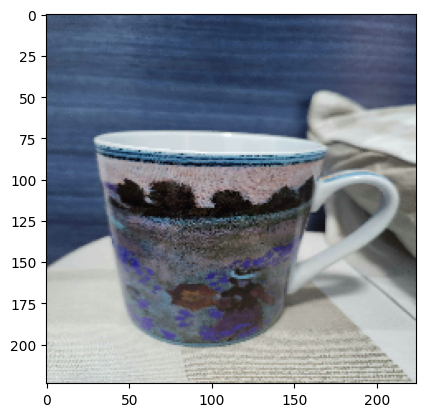

In [29]:
# Load the test image
test_number = 9
target_size = (224, 224)
img = cv2.imread('test_images/test' + str(test_number) + '.jpg')
resized_img = cv2.resize(img, target_size)
normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Add a new axis to create a batch of size 1
input_img = np.expand_dims(normalized_img, axis=0)

# Predict using the model
predictions = conv_model.predict(input_img)
predicted_class = (predictions > 0.5).astype(int)

# Display the predictions
plt.imshow(input_img.reshape((num_px, num_px, 3)))
print("prediction score is " + str(predictions))
print ("you predicted that it is " + classes[int(predicted_class[0][0])].decode("utf-8"))

In [ ]:
display(train_set_y)

In [34]:
test_set_x_resize = np.array([cv2.resize(img, (224, 224)) for img in test_set_x])

# Normalize the images to the range [0, 1]
test_set_x_normalized = test_set_x_resize.astype(np.float32)

# Make predictions on the entire batch at once
predictions = conv_model.predict(test_set_x_normalized)

# Convert predictions to binary classes based on threshold
predicted_classes = (predictions > 0.8).astype(int)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


In [35]:
test_set_y_flat = test_set_y.flatten()  # Shape (n_samples,)
predicted_classes_flat = predicted_classes.flatten()  # Shape (n_samples,)

# Calculate accuracy
accuracy = np.mean(test_set_y_flat == predicted_classes_flat)

# Print the accuracy
print('The accuracy of the model is: {:.2f}%'.format(accuracy * 100))


The accuracy of the model is: 94.75%


We can pick out some of the examples that we got wrong to see why it might be difficult for the model. 

[ 24  50  69 109 120 133 144 180 201 202 210 228 234 240 251 258 259 306
 311 312 318 326 334 346 355 357 425 437 516 527 567 576 581 596]


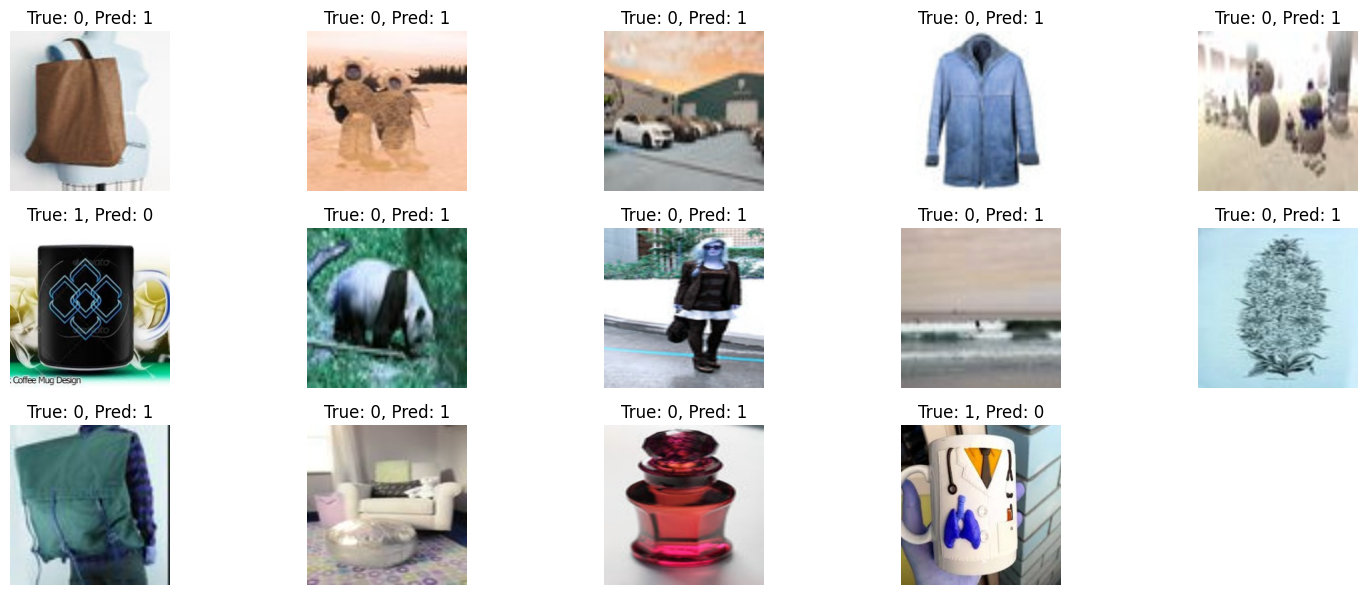

In [37]:

# Find indices of misclassified examples
misclassified_indices = np.where(test_set_y_flat != predicted_classes_flat)[0]
print(misclassified_indices)
correct_indices = np.where(test_set_y_flat == predicted_classes_flat)[0]
# Retrieve corresponding images from the test set
# Assuming test_images is your array of test images

start_index = 20
# Display the misclassified images
plt.figure(figsize=(15, 10))
for i, index in enumerate(misclassified_indices[start_index:start_index+25]):  # Display the first 10 misclassified images
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_set_X[index])  # Make sure images are in the right format
    plt.title(f"True: {test_set_y_flat[index]}, Pred: {predicted_classes_flat[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()